# Modeling Hypergraphs of MeSH Terms

## Model

* Let $G=(V,E)$ be a hypergraph, where $E$ is the collection of hyperedges.
* Let $H$ be the collection of admissible combinations of nodes, (e.g., if we only consider hyperedges of size less than 10). 
* $G$ is modeled as a collection of random variables ${X_h: h\in H}$.
* $X_h\sim Poisson(\lambda_h)$.
* The mean $\lambda_h$ depends on the (latent) features of nodes in $h$: $$\lambda_h=\sum_k\prod_{i\in h}r_i\theta_{ik},$$ where $\theta_{ik}$ is the percentage of node $i$ in block $k$  ($\sum_{k}\theta_{ik}=1$), and $r_i$ corresponds to the popularity of node $i$.
* Assume $X_h$'s are independent of each other given $\theta=(\theta_i)$ and $r=(r_i)$.
* The distribution of $G$ is given by $$p(G|\theta)=\prod_{h\in H} p(x_h|\theta)$$.
* Estimation: Use stochastic gradient descent to estimate $\theta$ and $r$
    * Let $\theta_{ij}=\theta_{ij}r_i$, so that we only need to deal with one set of variables $\theta$.

## Workbench

In [1]:
import time
import pandas as pd
import scipy.sparse as ssp
import numpy as np
from functools import partial
from multiprocessing import Pool, cpu_count
from scipy.stats import dirichlet
from collections import Counter
from datetime import datetime
import random
from collections import defaultdict
from scipy.optimize import minimize
from itertools import zip_longest
from numba import guvectorize,vectorize
from numba import int64,float64,int32
from numba import cuda
import math
import pickle as pickle
from scipy.stats import pearsonr
from sklearn.metrics import precision_recall_curve

In [2]:
%matplotlib inline
import pylab as plt
import seaborn as sns

In [3]:
class Stopwatch:
    start_time=None
    def go(self,msg=''):
        if msg:
            print(msg, flush=True)
        self.start_time=time.time()
    def stop(self,msg=''):
        if msg:
            print("{}: {} seconds".format(msg,time.time()-self.start_time), flush=True)
        else:
            print("Elapsed time: {} seconds".format(time.time()-self.start_time), flush=True)
    def check(self):
        return time.time()-self.start_time

tic=Stopwatch()

## Load data

In [4]:
def load_date(filename):
    tic=Stopwatch()
    print("Loading paper dates %s from disk..." % filename),
    tic.go()
    pkl_file = open(filename, 'rb')
    A=pickle.load(pkl_file,encoding='latin1')
    pkl_file.close()
    tic.stop()
    return A

def load_hypergraph(filename):
    tic=Stopwatch()
    print("Loading file %s from disk..." % filename),
    tic.go()
    pkl_file = open(filename, 'rb')
    (row,col) = pickle.load(pkl_file,encoding='latin1')
    pkl_file.close()
    A=ssp.coo_matrix((np.ones(len(row),dtype=np.int8),(row,col)),shape=(19916562, max(col)+1),dtype=np.int8)
    tic.stop()
    return A

In [5]:
tic=Stopwatch()
G=[]
for thing in ['chemical','disease','method']:
    G.append(load_hypergraph('../../Data/'+thing+'.pkl'))
G=ssp.hstack(G).tocsr()

paper_dates=load_date('../../Data/paper_dates.pkl') # Load publicatioin dates

Loading file ../../Data/chemical.pkl from disk...
Elapsed time: 13.912632465362549 seconds
Loading file ../../Data/disease.pkl from disk...
Elapsed time: 8.555835247039795 seconds
Loading file ../../Data/method.pkl from disk...
Elapsed time: 11.13637089729309 seconds
Loading paper dates ../../Data/paper_dates.pkl from disk...
Elapsed time: 2.9732871055603027 seconds


In [6]:
Counter(paper_dates)

Counter({-1: 3011366,
         1865: 3,
         1866: 11,
         1867: 36,
         1868: 95,
         1869: 58,
         1870: 69,
         1871: 62,
         1872: 38,
         1873: 96,
         1874: 39,
         1875: 73,
         1876: 87,
         1877: 46,
         1878: 119,
         1879: 143,
         1880: 118,
         1881: 98,
         1882: 88,
         1883: 108,
         1884: 159,
         1885: 209,
         1886: 196,
         1887: 234,
         1888: 182,
         1889: 195,
         1890: 240,
         1891: 207,
         1892: 227,
         1893: 309,
         1894: 308,
         1895: 296,
         1896: 340,
         1897: 314,
         1898: 324,
         1899: 335,
         1900: 254,
         1901: 329,
         1902: 416,
         1903: 642,
         1904: 715,
         1905: 861,
         1906: 765,
         1907: 689,
         1908: 703,
         1909: 748,
         1910: 700,
         1911: 806,
         1912: 862,
         1913: 936,
         1914:

In [6]:
G=G[paper_dates>0,:]
paper_dates=paper_dates[paper_dates>0]
G=G[paper_dates<2010,:]
paper_dates=paper_dates[paper_dates<2010]
paper_dates[paper_dates<1947]=1947

In [14]:
Counter(paper_dates)

Counter({1975: 221837,
         1976: 226115,
         1977: 232439,
         1978: 242206,
         1979: 251212,
         1974: 210733,
         1980: 249876,
         1992: 358775,
         1993: 364239,
         1990: 354127,
         1991: 355473,
         1988: 334360,
         1987: 317428,
         1985: 287918,
         1986: 300651,
         1989: 348124,
         1970: 195367,
         1969: 192312,
         1968: 184234,
         1967: 168406,
         1971: 199313,
         1964: 141892,
         1966: 156711,
         1972: 204058,
         1973: 207236,
         1965: 154666,
         1963: 125638,
         1962: 111271,
         1961: 105620,
         1960: 98229,
         1984: 279096,
         1982: 260583,
         1983: 272964,
         1981: 251146,
         1995: 383192,
         1994: 374184,
         1996: 389401,
         1997: 398176,
         1998: 412126,
         1999: 423046,
         2000: 450871,
         2001: 479434,
         2002: 500423,
         200

## Inference

In [9]:
def get_nodes(x,G):
    return tuple(sorted(G[x,:].nonzero()[1]))
    
def get_hyperedges(G):
    # G: a edge-by-node incidence matrix
    with Pool(cpu_count()-1) as pool:
        E=Counter(pool.map(partial(get_nodes,G=G), (G.sum(axis=1).A.flatten()>1).nonzero()[0]))
    return E

def get_random_combo(h, V, E):
    while True:
        e=tuple(sorted(random.sample(V,len(h))))
        if e not in E:
            return e

def batch_generator(iterable, batchsize, shuffle=False):
    if shuffle:
        iterable=list(iterable)
        random.shuffle(iterable)
    sentinel=object()
    return ([entry for entry in i if entry is not sentinel]
            for i in zip_longest(*([iter(iterable)]*batchsize), fillvalue=sentinel))

In [10]:
def edges2CSR(H):
    nodes=[]
    nodes_in=[0]
    for h in H:
        nodes+=list(h)
        nodes_in.append(len(nodes))
    return nodes, nodes_in

def CSR2CSC(nodes, nodes_in, N):
    M=ssp.csr_matrix((np.ones_like(nodes,dtype=np.int8), nodes, nodes_in), shape=(len(nodes_in)-1,N))
    M=M.tocsc()
    return M.indices, M.indptr            

@vectorize([float64(float64)], target='cuda')
def copy(x):
    return x

@guvectorize([(int64,float64[:,:],int64[:],int32[:],int32[:],int32[:],int32[:],int32[:],int32[:],int32[:],int32[:],int32[:],int32[:],float64[:])],
             '(),    (N0,K),      (N),     (M),     (N1),    (M),     (E1),    (E),     (M),     (N1),    (M),     (E1),    (D)  ->  (D)', target='cuda')
def dtheta(x,theta,active,edges,edges_in,nodes,nodes_in,weights,rand_edges,rand_edges_in,rand_nodes,rand_nodes_in,dummy,res):
    K=theta.shape[1]
    i=int(x/K)
    z=x-i*K
    res[0]=0.0
    for j in edges[edges_in[i]:edges_in[i+1]]:
        dlam=1.0
        for u in nodes[nodes_in[j]:nodes_in[j+1]]:
            if u!=i:
                dlam*=theta[active[u],z]
        p=0.0
        for k in range(K):
            prod=1.0
            for u in nodes[nodes_in[j]:nodes_in[j+1]]:
                prod*=theta[active[u],k]
            p+=prod
        p=max(p,1e-8)
        res[0]+=weights[j]*dlam/p-dlam 
            
    for j in rand_edges[rand_edges_in[i]:rand_edges_in[i+1]]:
        dlam=1.0
        for u in rand_nodes[rand_nodes_in[j]:rand_nodes_in[j+1]]:
            if u!=i:
                dlam*=theta[active[u],z]
        res[0]-=dlam

@cuda.jit
def preupdate(theta,theta0,r,s):
    x, y = cuda.grid(2)
    if x < theta.shape[0] and y < theta.shape[1]:
        theta[x,y]-=1.0/(100+r)*(theta[x,y]-theta0[x,y])/s

@cuda.jit
def update(theta,active,D,r):
    x, y = cuda.grid(2)
    if x < D.shape[0] and y < D.shape[1]:
        theta[active[x], y] += 1.0/(100+r)*D[x,y]
        cuda.atomic.max(theta, (active[x], y), 0.001)

@guvectorize([(int64,float64[:,:],int64[:],int32[:],int32[:],int32[:],int32[:],float64[:])], 
             '(),    (N,K),       (N0),    (M),     (E1),    (E),      (D)  ->  (D)', target='cuda')
def p_pos(i,theta,active,nodes,nodes_in,weights,dummy,res):
    p=0.0
    K=theta.shape[1]
    for k in range(K):
        prod=1.0
        for u in nodes[nodes_in[i]:nodes_in[i+1]]:
            prod*=theta[active[u],k]
        p+=prod
    if p<1e-15:
        res[0]=0
    else:
        res[0]=weights[i]*math.log(p) - p

@guvectorize([(int64,float64[:,:],int64[:],int32[:],int32[:],int32[:],float64[:])], 
             '(),    (N,K),       (N0),    (M),     (E1),    (D)  ->  (D)', target='cuda')
def p_neg(i,theta,active,rand_nodes,rand_nodes_in,dummy,res):
    p=0.0
    K=theta.shape[1]
    for k in range(K):
        prod=1.0
        for u in rand_nodes[rand_nodes_in[i]:rand_nodes_in[i+1]]:
            prod*=theta[active[u],k]
        p+=prod
    res[0]=-p

@cuda.reduce
def sum_reduce(a, b):
    return a + b

def logPG(theta,active,edges,edges_in,nodes,nodes_in,weights,rand_edges,rand_edges_in,rand_nodes,rand_nodes_in):
    res1=p_pos(range(weights.shape[0]),theta,active,nodes,nodes_in,weights,[0])
    sum1=sum_reduce(res1.ravel())
    res2=p_neg(range(rand_nodes_in.shape[0]-1),theta,active,rand_nodes,rand_nodes_in,[0])
    sum2=sum_reduce(res2.ravel())
    return (sum1+sum2)

def estimate(G, times, K=20, thetas=None, nepochs=5, subepochs=10, batchsize=1000, discontinue=1, outfile=None):
    # G: an edge-by-node incidence matrix; scipy sparse CSR matrix.
    # times: timestamp for each edge; 1D numpy array.
    # K: dimension of latent space.
    # thetas: intial values for the parameters; a list of node-by-K matrices with each matrix for a time point. If None, then the estimation starts from random matrices.
    # nepochs: number of repetitions of the whole process
    # subepochs: number of repetitions for each data point 
    # batchsize: batch size of training samples.
    # discontinue: correlation of the parameters between time points; the larger the value, the more dissimilar between time points.
    
    tic.go('Estimating...')
    candidate_times=np.unique(times)
    if thetas is None:
        theta=np.random.dirichlet([0.5]*K,size=G.shape[1])
        thetas=[cuda.to_device(theta)]
    else:
        if K!=thetas[0].shape[1]:
            raise("K and the dimension of initial condition don't match!")
        thetas=[thetas[0]]+thetas
        thetas=[cuda.to_device(theta) for theta in thetas]
    
    # parameters for CUDA
    threadsperblock = (32,min(32,K))
    blockspergrid_x = math.ceil(thetas[0].shape[0] / threadsperblock[0])
    blockspergrid_y = math.ceil(K / threadsperblock[1])
    blockspergrid0 = (blockspergrid_x, blockspergrid_y)
    
    likelihoods=[]
    for epoch in range(nepochs):
        time_index=1
        for t in candidate_times:
            if len(thetas)==time_index:
                thetas.append(copy(thetas[-1]))
            G0=G[(times==t).nonzero()[0],:]
            active_nodes=G0.sum(axis=0).A.ravel().nonzero()[0]
            G0=G0[:,active_nodes] 
            E0=get_hyperedges(G0)
            N=len(active_nodes)
            V=range(N)
            active_nodes=cuda.to_device(active_nodes)
            
            blockspergrid_x = math.ceil(N / threadsperblock[0])
            blockspergrid = (blockspergrid_x, blockspergrid_y)
                     
            if outfile:
                outfile.write("Epoch {} | Time: {} | Nodes: {} | Edges: {} | ".format(epoch,t,N,len(E0)))
                outfile.flush()
            
            for subepoch in range(subepochs):
                for batch in batch_generator(E0.items(),batchsize):
                    samples,weights=zip(*batch)
                    nodes,nodes_in=edges2CSR(samples)
                    edges,edges_in=CSR2CSC(nodes, nodes_in, N)  
                    nodes=cuda.to_device(np.array(nodes, dtype=np.int32))
                    nodes_in=cuda.to_device(np.array(nodes_in, dtype=np.int32))
                    weights=cuda.to_device(np.array(weights, dtype=np.int32))
                    edges=cuda.to_device(np.array(edges, dtype=np.int32))
                    edges_in=cuda.to_device(np.array(edges_in, dtype=np.int32))
#                     f=partial(get_random_combo, V=V, E=E0) # This sampling method is slower unless batchsize is huge
#                     with Pool(cpu_count()-1) as pool:
#                         E_neg=pool.map(f,samples)
                    E_neg=[]
                    for h in samples:
                        while True:
                            e=tuple(sorted(random.sample(V,len(h))))
                            if e not in E0:
                                E_neg.append(e)
                                break
                    rand_nodes, rand_nodes_in = edges2CSR(E_neg)
                    rand_edges, rand_edges_in = CSR2CSC(rand_nodes, rand_nodes_in, N)
                    rand_nodes=cuda.to_device(np.array(rand_nodes, dtype=np.int32))
                    rand_nodes_in=cuda.to_device(np.array(rand_nodes_in, dtype=np.int32))
                    rand_edges=cuda.to_device(np.array(rand_edges, dtype=np.int32))
                    rand_edges_in=cuda.to_device(np.array(rand_edges_in, dtype=np.int32))
                    preupdate[blockspergrid0, threadsperblock](thetas[time_index],thetas[time_index-1],(epoch+1)*(subepoch+1),discontinue)
                    D=dtheta(range(N*K),thetas[time_index],active_nodes,edges,edges_in,nodes,nodes_in,weights,rand_edges,rand_edges_in,rand_nodes,rand_nodes_in,[0])
                    D=D.reshape(N,K)      
                    update[blockspergrid, threadsperblock](thetas[time_index],active_nodes,D,(epoch+1)*(subepoch+1))        
                    l=logPG(thetas[time_index],active_nodes,edges,edges_in,nodes,nodes_in,weights,rand_edges,rand_edges_in,rand_nodes,rand_nodes_in)
                    likelihoods.append(l/len(samples))
            if outfile:
                outfile.write('log-lik: {:.2f} | Elapsed {:.2f} s\n'.format(likelihoods[-1], tic.check()))
                outfile.flush()
            time_index+=1
        thetas[0]=thetas[1]
    tic.stop()
    return (thetas[1:], likelihoods)

In [13]:
print("{}, # nodes: {} | # edges: {} | average degree: {} | average edge size: {}".format(datetime.now(),G.shape[1],G.shape[0],G.sum(axis=0).mean(),G.sum(axis=1).mean()))

2019-03-19 21:29:11.723705, # nodes: 15919 | # edges: 16905195 | average degree: 4547.891324831961 | average edge size: 4.282581892725875


In [14]:
K = 20 # dimension of hidden space

In [20]:
with open("output_medline_mesh.txt", 'w') as logfile:
    thetas,likelihoods=estimate(G,paper_dates,K,discontinue=1.0,nepochs=5,batchsize=1000,outfile=logfile)

Estimating...
Elapsed time: 48363.13294005394 seconds


In [23]:
thetas=[theta.copy_to_host() for theta in thetas]

In [51]:
with open('../Fitted_Model/block_model_medline_mesh.pkl','wb') as outfile2:
    pickle.dump([thetas,likelihoods,np.unique(paper_dates)],outfile2)

## Evaluation

In [9]:
with open('../../Fitted_Model/block_model_medline_mesh.pkl','rb') as infile:
    thetas,likelihoods,times=pickle.load(infile)

In [7]:
from evaluate import evaluate

In [10]:
res = evaluate(G, paper_dates, thetas)

Evaluating time 1948...
Evaluating time 1949...
Evaluating time 1950...
Evaluating time 1951...
Evaluating time 1952...
Evaluating time 1953...
Evaluating time 1954...
Evaluating time 1955...
Evaluating time 1956...
Evaluating time 1957...
Evaluating time 1958...
Evaluating time 1959...
Evaluating time 1960...
Evaluating time 1961...
Evaluating time 1962...
Evaluating time 1963...
Evaluating time 1964...
Evaluating time 1965...
Evaluating time 1966...
Evaluating time 1967...
Evaluating time 1968...
Evaluating time 1969...
Evaluating time 1970...
Evaluating time 1971...
Evaluating time 1972...
Evaluating time 1973...
Evaluating time 1974...
Evaluating time 1975...
Evaluating time 1976...
Evaluating time 1977...
Evaluating time 1978...
Evaluating time 1979...
Evaluating time 1980...
Evaluating time 1981...
Evaluating time 1982...
Evaluating time 1983...
Evaluating time 1984...
Evaluating time 1985...
Evaluating time 1986...
Evaluating time 1987...
Evaluating time 1988...
Evaluating time 

In [11]:
res.to_csv("../Results/MEDLINE_MeSH_evaluation.csv", index=False)
# res = pd.read_csv("../Results/MEDLINE_MeSH_evaluation.csv")

In [12]:
res.head()

,time,num_nodes,num_edges,mean_edge_size,max_edge_size,mean_degree,auc,auc_std,repeated_edges
0,1948,2488,2569,2.185675,6,10.819534,0.8459,0.007829,143
1,1949,2064,3636,2.245050,53,15.930717,0.9583,0.006589,478
2,1950,2203,8987,2.370869,32,28.710395,0.9492,0.006274,1108
3,1951,2534,10680,2.288577,8,29.824388,0.9594,0.004800,2377
4,1952,2115,10845,2.312218,10,37.018913,0.9725,0.005162,2807


In [13]:
res['frac_repeated']=res["repeated_edges"]/res["num_edges"]

In [14]:
df = res[res["time"]>=1966]

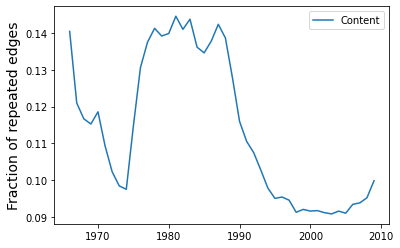

In [15]:
plt.plot(df["time"], df["frac_repeated"], label="Content");
plt.ylabel("Fraction of repeated edges", fontsize=14);
plt.legend();

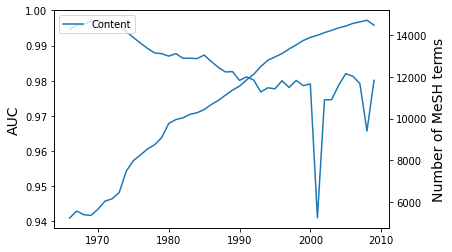

In [18]:
plt.plot(df["time"], df["auc"], label="MeSH");
ax = plt.gca();
ax2 = ax.twinx()
ax2.plot(df["time"], df["num_nodes"], label="Content")
ax.set_ylabel("AUC", fontsize=14);
ax2.set_ylabel("Number of MeSH terms", fontsize=14);
plt.legend();